This is your private sketch-notebook. Do whatever you want with it. When code is ready to be developed, please just copy and paste it to the final notebook. 

In [8]:
import sys
kaggle_path = '../../../Data/Kaggle/train/*'
sys.path.append('../../..')
from First_start.imports import *
from First_start.multi_gpu import *
from First_start.init_vars import *
from First_start.start_functions import *
%load_ext autoreload
%autoreload 2

In [ ]:
# Get x and y variables
x_train, y_train, x_test, y_test, image_df, dummy_df = get_xy(folders_path=kaggle_path, test_size=0.3,
                                                              img_size=(224, 224), seed=seed)

# Let's check the shape of those variables
print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# Own Code

(<matplotlib.axes._subplots.AxesSubplot at 0x7f67e7a80cd0>,
 <matplotlib.image.AxesImage at 0x7f67f062a150>)

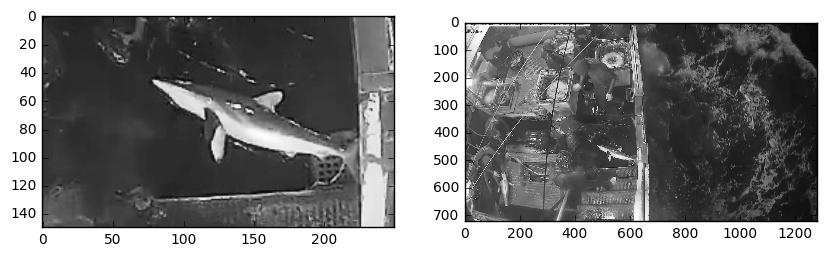

In [54]:
img_rows, img_cols= 150, 250
im_array = cv2.imread('../Data/Kaggle/train/SHARK/img_00033.jpg',0)
template = np.zeros([ img_rows, img_cols], dtype='uint8') # initialisation of the template
template[:, :] = im_array[400:550,400:650] # I try multiple times to find the correct rectangle. 
#template /= 255.
plt.subplots(figsize=(10, 7))
plt.subplot(121),plt.imshow(template, cmap='gray') 
plt.subplot(122), plt.imshow(im_array, cmap='gray')

In [55]:
file_name = '../Data/Kaggle/train/SHARK/img_01166.jpg' # img_00176,img_02758, img_01512
img = cv2.imread(file_name,0) 
img2 = img
w, h = template.shape[::-1]

# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for meth in methods:
     img = img2
     method = eval(meth)
 
     # Apply template Matching
     res = cv2.matchTemplate(img,template,method)
     min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
 
     # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
     if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
         top_left = min_loc
     else:
         top_left = max_loc
     bottom_right = (top_left[0] + w, top_left[1] + h)
 
     cv2.rectangle(img,top_left, bottom_right, 255, 2)
     fig, ax = plt.subplots(figsize=(12, 7))
     plt.subplot(121),plt.imshow(res,cmap = 'gray')
     plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
     plt.subplot(122),plt.imshow(img,cmap = 'gray') #,aspect='auto'
     plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
     plt.suptitle(meth)
 
     plt.show()

error: /io/opencv/modules/imgproc/src/templmatch.cpp:664: error: (-215) corrsize.height <= img.rows + templ.rows - 1 && corrsize.width <= img.cols + templ.cols - 1 in function crossCorr


In [9]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(3, 224, 224), border_mode='same', activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same', W_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))
# Compile model
epochs = 1 # dont leave it like this, only for testing!
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 224, 224)  896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 32, 224, 224)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 224, 224)  9248        dropout_1[0][0]                  
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 112, 112)  0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [10]:
# Fit the model
model.fit(x_train, y_train, validation_data=(x_test, y_test), nb_epoch=epochs, batch_size=32)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
classes = model.predict_proba(x_test, batch_size=32)

# get probability table
proba_df = pd.DataFrame(classes)
proba_df.columns = image_df.groupby('fish_type').count().index # workaround to get column names quickly and in right order

print("Accuracy: %.2f%%" % (scores[1]*100))
print ' '
proba_df

Train on 90 samples, validate on 11 samples
Epoch 1/1
11/11 [==============================] - 0s
Accuracy: 36.36%
 


fish_type,ALB,ARK,BET,DOL,HER,LAG,NoF,YFT
0,0.423125,0.069086,0.086060,0.035125,0.109103,0.022536,0.064302,0.190663
1,0.421642,0.070203,0.076487,0.054563,0.122197,0.040422,0.075519,0.138968
2,0.458518,0.065818,0.069579,0.051640,0.119346,0.038697,0.066064,0.130337
3,0.416392,0.069272,0.080653,0.050310,0.134840,0.031809,0.071212,0.145512
4,0.404307,0.073336,0.082809,0.052671,0.124707,0.041288,0.074341,0.146541
5,0.235705,0.108864,0.123543,0.076935,0.120574,0.061900,0.100954,0.171525
6,0.436765,0.064467,0.067968,0.051210,0.118235,0.034705,0.072924,0.153726
7,0.398049,0.078053,0.081770,0.044163,0.135299,0.028894,0.061562,0.172210
8,0.326164,0.086616,0.098806,0.074431,0.127018,0.054024,0.086574,0.146366
9,0.285160,0.088849,0.098600,0.082511,0.122335,0.060240,0.097439,0.164866
